<a href="https://colab.research.google.com/github/mariampinel/Neural-Networks-Deep-Learning/blob/main/NN_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim


In [15]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 771.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

## Notes
- Fix dimensions
- Task 2
- Use: Convolutional neural networks are an example of architecture that exploits domain knowledge to improve performance.-> Find domain knowledge

# Task 1: Create a DataLoader for the training dataset and a DataLoader for the testing dataset, which should enable generating batches of examples

In [37]:
# Define transformation to apply normalization and augmentation to training data
def get_transforms(resize=None):
    transform_list = [torchvision.transforms.ToTensor()]

    if resize:
        transform_list.insert(0, torchvision.transforms.Resize(resize))

    transform_train = torchvision.transforms.Compose(transform_list)
    transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    return transform_train, transform_test

# Load CIFAR-10 datasets using transformations
def load_data_cifar10(batch_size, transform_train, transform_test):
    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=transform_train, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=transform_test, download=True)

    train_loader = torch.utils.data.DataLoader(
        cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


In [38]:
# Create train, validation and test split
# Setting up hyperparameters and data loading
batch_size = 256  # Modify batch size as required
transform_train, transform_test = get_transforms(resize=None)
train_loader, test_loader = load_data_cifar10(batch_size, transform_train, transform_test)


In [13]:
# Version checks
# print(torch.__version__)
# print(torchvision.__version__)


2.6.0+cu124
0.21.0+cu124


In [39]:
# Create vars X and y
# Create vars X and y
X, y = next(iter(train_loader))  # Requests the first training batch from train_loader
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 32 x 32 tensor (number of channels x height x width). The images are color, so there are 3 channels.
print(y.size()) # 256 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([256, 3, 32, 32])
torch.Size([256])



Image 0 (bird):



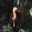


Image 1 (truck):



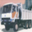


Image 2 (truck):



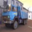


Image 3 (horse):



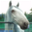


Image 4 (cat):



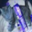


Image 5 (truck):



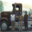


Image 6 (airplane):



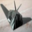


Image 7 (deer):



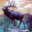

In [31]:
# Visualize data
from google.colab.patches import cv2_imshow

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Pre-defined class labels

for i in range(8):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.

# Task 2: Implement the neural network architecture as described in this section to classify images from the CIFAR-10 dataset.

The architecture is composed of a sequence of intermediate blocks B1, B2, . . . , BK that are followed by an output block O, as shown in Figure 2. These blocks are detailed in the following subsections.

## Implement intermediate blocks

In [80]:
class IntermediateBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.num_layers = num_layers  # Store num_layers as an instance variable

        # Independent convolutional layers
        self.convs = torch.nn.ModuleList([
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)
        ])

        # Fully connected layer to compute importance weights (a)
        self.fc = torch.nn.Linear(in_channels, num_layers)

    def forward(self, x):
        batch_size, c, h, w = x.shape

        # Apply each convolution independently
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)  # (batch, num_layers, out_channels, h, w)

        # Compute per-channel average of x (to form m)
        m = x.mean(dim=[2, 3])  # (batch, in_channels), average over height and width

        # Compute weight vector a
        a = self.fc(m)  # (batch, num_layers)
        a = torch.softmax(a, dim=1)  # Normalize weights along num_layers

        # Reshape a for broadcasting to the shape of conv_outputs
        a = a.view(batch_size, self.num_layers, 1, 1)  # Use self.num_layers here

        # Expand a to match the spatial dimensions of conv_outputs
        a = a.expand(-1, -1, h, w)  # (batch, num_layers, h, w)

        # Weighted sum of convolutional outputs
        weighted_conv_outputs = (a.unsqueeze(2) * conv_outputs).sum(dim=1)  # (batch, out_channels, h, w)

        return weighted_conv_outputs



The output block receives an image x (output of the last intermediate block) and outputs a logits vector o. Suppose that the input image x has c channels. In order to compute the vector o, the average value of each channel of x is computed and stored into a c-dimensional vector m. The vector m is the input to a sequence of zero or more fully connected layer(s) that output the vector o.
c in this case is 3. Singe the images have 3 channels because they have colour.

In [81]:
# Output Block
class OutputBlock(torch.nn.Module):
    def __init__(self, num_outputs, in_channels, num_hidden_units=512, activation_function=torch.nn.ReLU):
        super(OutputBlock, self).__init__()

        # Define the fully connected layers for the output block
        self.fc1 = torch.nn.Linear(in_channels, num_hidden_units)
        self.fc2 = torch.nn.Linear(num_hidden_units, num_hidden_units // 4)  # Reduced size
        self.fc3 = torch.nn.Linear(num_hidden_units // 4, num_outputs)

        # Choose activation function
        self.activation_function = activation_function

    def forward(self, x):
        # Compute the per-channel average of x (global average pooling)
        m = x.mean(dim=[2, 3])  # (batch, in_channels), average over height and width

        # Pass the average through fully connected layers with activation functions
        x = self.activation_function(self.fc1(m))
        x = self.activation_function(self.fc2(x))
        x = self.fc3(x)

        return x


In [82]:
# CIFAR-10 Classifier with Intermediate and Output blocks
class CIFAR10Classifier(torch.nn.Module):
    def __init__(self, num_classes=10, num_hidden_units=512, num_layers=3, activation_function=torch.nn.ReLU):
        super(CIFAR10Classifier, self).__init__()

        # Define intermediate blocks
        self.block1 = IntermediateBlock(in_channels=3, out_channels=num_hidden_units, num_layers=num_layers)
        self.block2 = IntermediateBlock(in_channels=num_hidden_units, out_channels=num_hidden_units * 2, num_layers=num_layers)
        self.block3 = IntermediateBlock(in_channels=num_hidden_units * 2, out_channels=num_hidden_units * 4, num_layers=num_layers)

        # Define the output block
        self.output_block = OutputBlock(num_outputs=num_classes, in_channels=num_hidden_units * 4)

    def forward(self, x):
        # Pass through each intermediate block
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Pass through the output block for final classification
        x = self.output_block(x)
        return x



- Weight inizialization

In [83]:
# Define weight initialization function
def weight_init(m):
    # Apply He initialization to Conv2d and Linear layers
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


In [51]:
# DELETE
# # Create the model with the current hyperparameters
# model = CIFAR10Classifier(
#     num_classes=10,
#     num_hidden_units=hidden_units,
#     num_layers=layers,
#     activation_function=activation
# )

# # Apply weight initialization
# model.apply(weight_init)  # Apply custom weight initialization


TypeError: OutputBlock.__init__() got an unexpected keyword argument 'num_hidden_units'

- Loss function

- Optimizer

In [84]:

# Train function
def train(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Evaluation function to check accuracy on the test dataset
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_accuracy += (predicted == targets).sum().item()
            total_samples += targets.size(0)
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / total_samples * 100
    return avg_loss, avg_accuracy


In [85]:
# Hyperparameter grid search
learning_rates = [1e-3, 1e-4]
batch_sizes = [128, 256]
num_hidden_units = [512, 1024]
activations = [torch.nn.ReLU, torch.nn.Sigmoid]
num_layers = [3, 4]

best_val_accuracy = 0
best_model = None
best_hyperparams = None

# Loop over all combinations of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for hidden_units in num_hidden_units:
            for activation in activations:
                for layers in num_layers:
                    print(f"Training with lr={lr}, batch_size={batch_size}, hidden_units={hidden_units}, activation={activation}, num_layers={layers}")

                    # Create the model with the current hyperparameters
                    model = CIFAR10Classifier(
                        num_classes=10,
                        num_hidden_units=hidden_units,
                        num_layers=layers,
                        activation_function=activation
                    )

                    # Apply weight initialization
                    model.apply(weight_init)

                    # Set up the optimizer (using Adam with the current learning rate)
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Load data with the current batch size
                    train_loader, test_loader = load_data_cifar10(batch_size=batch_size, transform_train=transform_train, transform_test=transform_test)

                    # Define the loss function
                    criterion = torch.nn.CrossEntropyLoss()

                    # Train the model
                    train(model, train_loader, optimizer, criterion, num_epochs=10)

                    # Evaluate on the testing dataset (acting as validation)
                    val_loss, val_accuracy = evaluate(model, test_loader, criterion)

                    # Save the best model based on validation accuracy
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_model = model
                        best_hyperparams = {
                            'lr': lr,
                            'batch_size': batch_size,
                            'hidden_units': hidden_units,
                            'activation': activation,
                            'num_layers': layers
                        }
                        print(f"New best model with accuracy {val_accuracy}%")

# Print the best hyperparameters found
print(f"Best model achieved with hyperparameters: {best_hyperparams}")



Training with lr=0.001, batch_size=128, hidden_units=512, activation=<class 'torch.nn.modules.activation.ReLU'>, num_layers=3


KeyboardInterrupt: 

. Train model

In [ ]:

# Train the model
train(model, train_loader, optimizer, criterion, num_epochs=10)

- Evaluate model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

In [ ]:
# Loop over all combinations of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for hidden_units in num_hidden_units:
            for activation in activations:
                for layers in num_layers:
                    print(f"Training with lr={lr}, batch_size={batch_size}, hidden_units={hidden_units}, activation={activation}, num_layers={layers}")

                    # Create the model with the current hyperparameters
                    model = CIFAR10Classifier(num_classes=10, num_hidden_units=hidden_units, num_layers=layers, activation_function=activation, batch_size=batch_size)

                    # Apply weight initialization
                    model.apply(weight_init)

                    # Set up the optimizer
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Load data with the current batch size
                    train_loader, val_loader, test_loader = load_data_cifar10(batch_size=batch_size, transform_train=transform_train, transform_test=transform_test)

                    # Define the loss function
                    criterion = torch.nn.CrossEntropyLoss()

                    # Train the model
                    train(model, train_loader, optimizer, criterion, num_epochs=10)

                    # Evaluate on the validation set
                    val_loss, val_accuracy = evaluate(model, val_loader, criterion)

                    # Save the best model based on validation accuracy
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_model = model
                        best_hyperparams = {
                            'lr': lr,
                            'batch_size': batch_size,
                            'hidden_units': hidden_units,
                            'activation': activation,
                            'num_layers': layers
                        }
                        print(f"New best model with accuracy {val_accuracy}%")

print(f"Best model achieved with hyperparameters: {best_hyperparams}")


- Losss function

In [ ]:
loss = torch.nn.CrossEntropyLoss()

- Optimization algorithm

In [ ]:
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

- Evaluation

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

In [ ]:
def evaluate_metric(net, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.)
    n = torch.tensor(0.)
    for X, y in data_iter:
        logits = net(X)
        c += metric(logits, y)
        n += len(y)

    return c / n

In [ ]:
print(f'Training accuracy: {evaluate_metric(net, train_iter, correct)}. Testing accuracy: {evaluate_metric(net, test_iter, correct)}.')

In [ ]:
# References
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.